In [2589]:
#importing the libraries
import os
import numpy as np
import pandas as pd
import csv
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import tree, ensemble, metrics, cross_validation, externals

pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 40)

%matplotlib inline
plt.style.use('ggplot')
%matplotlib inline
plt.style.use('ggplot')

In [2590]:
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py

Installed gvmagic.py. To use it, type:
  %load_ext gvmagic


## Function Definitions

## Creating a Data Frame

In [2591]:
df = pd.read_csv('Kaggle_YourCabs_training.csv')

In [2592]:
df.columns


Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error'],
      dtype='object')

## Quick Analysis for the dependant variable

In [2593]:
df['Car_Cancellation'].value_counts()


0    40299
1     3132
Name: Car_Cancellation, dtype: int64

# Vehicle Model id and its transformation:
## Approach- Create a new categorical feature 'vehicle_type' that contains the popularity of the vehicle type_id, 1 being the most popular

In [2594]:
df.vehicle_model_id.unique()

array([28, 12, 65, 24, 87, 54, 85, 17, 23, 36, 72, 30, 43, 86, 76,  1, 69,
       14, 89, 10, 13, 64, 90, 75, 70, 91, 39])

In [2595]:
df.vehicle_model_id.value_counts()

12    31859
85     2407
89     2391
65     1912
28     1702
24     1494
87      565
90      312
23      297
86      123
      ...  
13        7
43        2
72        2
1         2
75        1
76        1
39        1
70        1
69        1
14        1
Name: vehicle_model_id, dtype: int64

In [2596]:
df.vehicle_model_id.isnull().sum()

0

# Transformation

Note-vehicle_model_id is the model type

In [2597]:
print range(len(df.vehicle_model_id.value_counts()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


### The code below creates a Dataframe with model_id and vehicle_counts 

In [2598]:
p =  df.vehicle_model_id.value_counts()
print p.index
print p.values
vehicle_cat_df = pd.DataFrame({ 'model_id':p.index , 'vehicle_count':p.values })
vehicle_cat_df.head(20)

Int64Index([12, 85, 89, 65, 28, 24, 87, 90, 23, 86, 10, 64, 54, 17, 91, 30, 36,
            13, 43, 72,  1, 75, 76, 39, 70, 69, 14],
           dtype='int64')
[31859  2407  2391  1912  1702  1494   565   312   297   123   104    85
    73    40    25    14     9     7     2     2     2     1     1     1
     1     1     1]


,model_id,vehicle_count
0,12,31859
1,85,2407
2,89,2391
3,65,1912
4,28,1702
5,24,1494
6,87,565
7,90,312
8,23,297
9,86,123


In [2599]:
#This function categories the vehicle_types into categories, based on the %ages of popular vehicles
def categorize_vehicle():
    #Cat_1 is the most popular vehicle
    cat_1 = vehicle_cat_df.vehicle_count.max()
    cat_2 = round(vehicle_cat_df.vehicle_count.quantile(.75))
    cat_3 = round(vehicle_cat_df.vehicle_count.quantile(.5))
    cat_4 = round(vehicle_cat_df.vehicle_count.quantile(.25))
    
    # Level 2 is the %age of vehicle between 75% and max
    level_2 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_1) & (vehicle_cat_df.vehicle_count >=cat_2)]
    count = len(level_2)
    for i in range(len(level_2)):
        print "The value of model id being processeed is %r.." %level_2.model_id[i+1]
        df.loc[df['vehicle_model_id'] == level_2.model_id[i+1] ,'vehicle_type'] = 2
    print df.vehicle_type.value_counts()
    
    # 75 to 50%
    level_3 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_2) & (vehicle_cat_df.vehicle_count >=cat_3)]
    j = count+1
    for i in range(1,len(level_3)):
        print "The value of model id being processeed is %r.." %level_3.model_id[j]
        
        df.loc[df['vehicle_model_id'] == level_3.model_id[j] ,'vehicle_type'] = 3
        j+=1
    print df.vehicle_type.value_counts()
    
    # 50 to 25%
    level_4 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_3) & (vehicle_cat_df.vehicle_count >=cat_4)]
    k = j+1
    for i in range(1,(len(level_4))):
        print "The value of model id being processeed is %r.." %level_4.model_id[k]
        df.loc[df['vehicle_model_id'] == level_4.model_id[k] ,'vehicle_type'] = 4
        k+=1
    print df.vehicle_type.value_counts()
    
    # 25 and below
    l = k+1
    level_5 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_4) & (vehicle_cat_df.vehicle_count > 0)]
    for i in range(1,(len(level_5))):
        print "The value of model id being processeed is %r.." %level_5.model_id[l]
        df.loc[df['vehicle_model_id'] == level_5.model_id[l] ,'vehicle_type'] = 5
        l+=1
    print df.vehicle_type.value_counts()

        

### The code below creates the range on vehicle_categories and call the function categorization

In [2600]:


df['vehicle_type'] = '1'

# Categorizing levels
categorize_vehicle()





The value of model id being processeed is 85..
The value of model id being processeed is 89..
The value of model id being processeed is 65..
The value of model id being processeed is 28..
The value of model id being processeed is 24..
The value of model id being processeed is 87..
1    32960
2    10471
Name: vehicle_type, dtype: int64
The value of model id being processeed is 90..
The value of model id being processeed is 23..
The value of model id being processeed is 86..
The value of model id being processeed is 10..
The value of model id being processeed is 64..
The value of model id being processeed is 54..
1    31966
2    10471
3      994
Name: vehicle_type, dtype: int64
The value of model id being processeed is 91..
The value of model id being processeed is 30..
The value of model id being processeed is 36..
The value of model id being processeed is 13..
The value of model id being processeed is 43..
The value of model id being processeed is 72..
1    31907
2    10471
3      994


Note:- 31K (of 43K~72%) of all the vehciles rented are of Model_id=12


# Exploring the feature from_city_id:
This represents unique identifier of city


In [2601]:
df.from_city_id.isnull().sum()

27086

In [2602]:
df[df.Car_Cancellation==1][['from_city_id']].isnull().sum()

from_city_id    1441
dtype: int64

In [2603]:
df[['from_city_id','Car_Cancellation']].corr()

,from_city_id,Car_Cancellation
from_city_id,1.000000,0.024755
Car_Cancellation,0.024755,1.000000


## Analysis and Transformation on User_id
The idea is to classify all the booking to check if this has been booked form a frequent user 

In [2604]:
len(df.user_id.unique())


22267

In [2605]:
(df.user_id.value_counts() > 1).sum()

6332

In [2606]:
df['frequent_user_1']=0


#### 22267 unique users and out of which 6332 have reused the service 

#### Creating a new feature frequent_user and initializing it to 0

In [2714]:
df['frequent_user'] = 0

In [2613]:
#categorize_user()
#df.frequent_user_1.value_counts()

In [2715]:
# This is a series with TRUE for each of the user id that has booked multiple times
is_frequent = df.user_id.value_counts()>1
#p =  df.vehicle_model_id.value_counts()
print is_frequent.index
print is_frequent.values


Int64Index([29648,   868, 27458, 32527, 34972, 33002, 29275, 32023, 30290,
            38538,
            ...
            42119, 29853, 44198, 27806, 25759, 38049, 36002, 48292, 46245,
             8196],
           dtype='int64', length=22267)
[ True  True  True ..., False False False]


In [2615]:
#The function below takes the user_id as input and checks the value against the index of the series, returns 1 for True and 0 for False
def check_frequent(user_id):
    if is_frequent.ix[user_id]==True:
        return '1'
    else:
        return '0'

In [2716]:
#Calling function on the second column(user_id) for each of the rows
#df.head()
df['frequent_user']= df.iloc[:, 1].apply(check_frequent)

In [2717]:
#df['frequent_user']=df['frequent_user_1']
df.frequent_user.value_counts()

1    27496
0    15935
Name: frequent_user, dtype: int64

In [2618]:
df.frequent_user.isnull().sum()

0

## from_Areaid and to_area_id

In [2619]:
len(df.from_area_id.unique())
#599 unique values for Area id 

599

In [2620]:
df.from_area_id.value_counts()

393.0     3858
571.0     1631
293.0     1052
585.0      911
1010.0     768
142.0      727
83.0       719
1384.0     628
1096.0     542
58.0       466
          ... 
1277.0       1
1380.0       1
802.0        1
1252.0       1
235.0        1
369.0        1
1127.0       1
1125.0       1
1253.0       1
1403.0       1
Name: from_area_id, dtype: int64

In [2621]:
df.from_area_id.value_counts().mean()

72.4799331103679

In [2622]:
(df.from_area_id.value_counts()<72).sum()

444

In [2623]:
(df.from_area_id.value_counts()>72).sum()

154

#### 72 is the mean value of the no of booking from a specific area , on a closer look it seems that out of 599 areas served by the company , a majority of the areas 444, have less than the avg no of booking per area and around 154 areas have higher than the avg no of booking per area

In [2624]:
len(df.from_area_id.unique())

599

In [2625]:
len(df.to_area_id.unique())

569

In [2626]:
df.from_area_id.value_counts()>df.from_area_id.value_counts().mean()

393.0      True
571.0      True
293.0      True
585.0      True
1010.0     True
142.0      True
83.0       True
1384.0     True
1096.0     True
58.0       True
          ...  
1277.0    False
1380.0    False
802.0     False
1252.0    False
235.0     False
369.0     False
1127.0    False
1125.0    False
1253.0    False
1403.0    False
Name: from_area_id, dtype: bool

In [2627]:
# the function below will check the from_booking location is greater than the Mean value of the most frequent booking
# If yes , populate the popular_pickup to 1 else populate it to 0

df['Popular_Pickup']='0'
is_popular_pickup = df.from_area_id.value_counts()>df.from_area_id.value_counts().mean()

def check_popular(area_id):
    if is_popular_pickup.ix[area_id].any()==True:
        return '1'
    else:
        return '0'

    
    
def check_popular_Drop(area_id):
    if is_popular_Drop.ix[area_id].any()==True:
        return '1'
    else:
        return '0'

In [2628]:

df['Popular_Pickup'] = df.iloc[:, 5].apply(check_popular)


In [2629]:
df.Popular_Pickup.value_counts()

1    34259
0     9172
Name: Popular_Pickup, dtype: int64

In [2630]:
df.Popular_Pickup.isnull().sum()

0

In [2631]:
len(df.to_area_id.unique())

569

In [2632]:
df.to_area_id.value_counts()

393.0     8777
585.0     2339
1384.0    1237
571.0      664
293.0      555
1010.0     480
83.0       365
168.0      338
1371.0     332
452.0      330
          ... 
201.0        1
1196.0       1
1201.0       1
1207.0       1
1233.0       1
174.0        1
1252.0       1
1266.0       1
1271.0       1
1403.0       1
Name: to_area_id, dtype: int64

In [2633]:
df.to_area_id.value_counts().mean()

60.375

In [2634]:
(df.to_area_id.value_counts()>60).sum()

104

### #### 60 is the mean value of the no of booking from a specific area , on a closer look it seems that out of 569 areas served by the company , a majority of the areas 462, have less than the avg no of booking per area and around 104 areas have higher than the avg no of booking per area

In [2635]:
df['Popular_Drop']='0'
is_popular_Drop = df.to_area_id.value_counts()>df.to_area_id.value_counts().mean()


In [2636]:
df['Popular_Drop'] = df.iloc[:, 6].apply(check_popular_Drop)


In [2637]:
df.Popular_Drop.value_counts()

1    26994
0    16437
Name: Popular_Drop, dtype: int64

In [2638]:
df.Popular_Drop.isnull().sum()

0

## to_city_id - unique identifier of city (only for intercity)


In [2639]:
df.to_city_id.isnull().sum()

41843

In [2640]:
#### 41 K out of 43 K have Null values- Definitely Drop it

## getting rid of package_id which has ~35K null values,vehicle_model_id,to_city_id

## DATE Fields-from_date- Timestamp of the requested trip start

In [2641]:
len(df.from_date.unique())

20377

In [2642]:
df.from_date

0           1/1/13 2:00
1           1/1/13 9:00
2           1/1/13 3:30
3           1/1/13 5:45
4           1/1/13 9:00
5          1/1/13 22:30
6           1/1/13 9:45
7          1/1/13 11:00
8          1/1/13 16:00
9          1/1/13 11:00
              ...      
43421     11/25/13 9:45
43422    11/24/13 21:15
43423    11/24/13 16:00
43424    11/24/13 15:15
43425     11/25/13 0:00
43426    11/24/13 18:00
43427     11/26/13 1:00
43428    11/24/13 18:30
43429    11/24/13 16:00
43430     11/25/13 5:00
Name: from_date, dtype: object

In [2643]:
#df.DateTime[-1]
type(df.from_date[1])

str

#### Transforming a string value to Date time on from_Date and To_Date

In [2644]:
df.from_date = pd.to_datetime(df.from_date)

In [2645]:
df.from_date.apply(lambda date: date.month)

0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
         ..
43421    11
43422    11
43423    11
43424    11
43425    11
43426    11
43427    11
43428    11
43429    11
43430    11
Name: from_date, dtype: int64

In [2646]:
type(df.from_date[1])

pandas.tslib.Timestamp

In [2647]:
df.from_date[1].month

1

In [2648]:
def get_month(x):
    return x.month





df['Req_start_Month'] = df['from_date'].apply(get_month)

In [2649]:
df.Req_start_Month.value_counts().isnull()

8     False
7     False
10    False
9     False
6     False
5     False
11    False
4     False
2     False
1     False
3     False
12    False
Name: Req_start_Month, dtype: bool

In [2650]:
df.to_date = pd.to_datetime(df.to_date)
df['Req_end_Month'] = df['to_date'].apply(get_month)

In [2651]:
df.to_date

Flushing oldest 200 entries.


0                                 NaT
1                                 NaT
2                                 NaT
3                                 NaT
4                                 NaT
5                                 NaT
6       1970-01-01 00:00:00.000041275
7                                 NaT
8                                 NaT
9                                 NaT
                     ...             
43421   1970-01-01 00:00:00.000041603
43422   1970-01-01 00:00:00.000041602
43423   1970-01-01 00:00:00.000041602
43424   1970-01-01 00:00:00.000041603
43425   1970-01-01 00:00:00.000041603
43426   1970-01-01 00:00:00.000041602
43427   1970-01-01 00:00:00.000041604
43428   1970-01-01 00:00:00.000041602
43429   1970-01-01 00:00:00.000041602
43430   1970-01-01 00:00:00.000041603
Name: to_date, dtype: datetime64[ns]

### Note- The to_date seems to have a junk value as it has a default 1970 date- should be ignored

In [2652]:
df.booking_created

0           1/1/13 1:39
1           1/1/13 2:25
2           1/1/13 3:08
3           1/1/13 4:39
4           1/1/13 7:53
5           1/1/13 8:01
6           1/1/13 9:21
7           1/1/13 9:39
8           1/1/13 9:44
9           1/1/13 9:49
              ...      
43421    11/24/13 14:10
43422    11/24/13 14:12
43423    11/24/13 14:15
43424    11/24/13 14:23
43425    11/24/13 14:24
43426    11/24/13 14:25
43427    11/24/13 14:30
43428    11/24/13 14:35
43429    11/24/13 14:43
43430    11/24/13 14:50
Name: booking_created, dtype: object

In [2653]:
df.booking_created = pd.to_datetime(df.booking_created)

df['Creation_Month'] = df['booking_created'].apply(get_month)

In [2654]:
df.Creation_Month.value_counts()

8     5627
7     4925
10    4924
9     4778
6     4420
5     4311
4     3156
1     2937
2     2874
3     2822
11    2657
Name: Creation_Month, dtype: int64

In [2655]:
df[(df.Creation_Month) !=(df.Req_start_Month)].count()

id                  2308
user_id             2308
vehicle_model_id    2308
package_id           164
travel_type_id      2308
from_area_id        2306
to_area_id          2020
from_city_id        1461
to_city_id           124
from_date           2308
                    ... 
Car_Cancellation    2308
Cost_of_error       2308
vehicle_type        2308
frequent_user_1     2308
frequent_user       2308
Popular_Pickup      2308
Popular_Drop        2308
Req_start_Month     2308
Req_end_Month       1812
Creation_Month      2308
dtype: int64

#### Appears that there are 2308 records for which booking was created in advance of the trip start date

## Geographic information:
1)from_lat - latitude of from area
2)from_long -  longitude of from area
3)to_lat - latitude of to area
4)to_long - longitude of to area


In [2656]:
df.from_lat.value_counts()

13.199560    3858
12.951850    1631
12.976770    1080
12.849482    1052
12.924150     960
13.028530     928
12.966910     776
12.912810     732
12.965190     726
12.974400     468
             ... 
12.969520       1
12.923680       1
12.957324       1
12.998700       1
12.963180       1
13.031318       1
12.972380       1
12.946000       1
13.062130       1
13.032010       1
Name: from_lat, dtype: int64

In [2657]:
len(df.from_lat.unique())

467

In [2658]:
df.from_lat.value_counts()

13.199560    3858
12.951850    1631
12.976770    1080
12.849482    1052
12.924150     960
13.028530     928
12.966910     776
12.912810     732
12.965190     726
12.974400     468
             ... 
12.969520       1
12.923680       1
12.957324       1
12.998700       1
12.963180       1
13.031318       1
12.972380       1
12.946000       1
13.062130       1
13.032010       1
Name: from_lat, dtype: int64

In [2659]:
len(df.from_lat.unique())

467

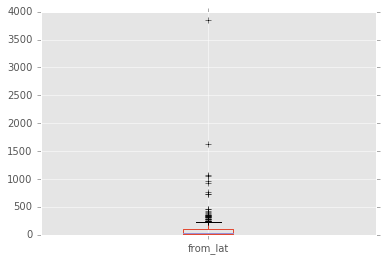

In [2660]:
df.from_lat.value_counts().plot(kind='box')

### The latitude data for Bangalore is between 12 and 13, accordingly creating a new feature called from_outside City that represents if the booking pickup is outside the city 

In [2661]:
df['from_Outside_City'] = 0

In [2662]:
df.from_Outside_City.value_counts()

0    43431
Name: from_Outside_City, dtype: int64

In [2663]:
def check_intercity(x):
    if (x >=12) & (x <=13):
        return '1'
    elif pd.isnull(x)==True:
            return '1'
    else:
        return '0'

In [2664]:
#df['Creation_Month'] = df['booking_created'].apply(get_month)
df['from_Outside_City'] = df['from_lat'].apply(check_intercity)

In [2665]:
df.from_Outside_City.value_counts()


1    31490
0    11941
Name: from_Outside_City, dtype: int64

In [2666]:
df.from_Outside_City.isnull().sum()

0

In [2667]:
df['To_Outside_City'] = 0

In [2668]:
df['To_Outside_City'] = df['to_lat'].apply(check_intercity)

In [2669]:
df.To_Outside_City.value_counts()

1    28886
0    14545
Name: To_Outside_City, dtype: int64

In [2670]:
df.columns

Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error',
       u'vehicle_type', u'frequent_user_1', u'frequent_user',
       u'Popular_Pickup', u'Popular_Drop', u'Req_start_Month',
       u'Req_end_Month', u'Creation_Month', u'from_Outside_City',
       u'To_Outside_City'],
      dtype='object')

**Variable** | **__ Description__** |** Analysis**|**Present**
---|---|---
id|The id of the booking|Unique id representing the booking|No
user_id|user_id of the person making the booking|22K unique values, transformed into frequent_user|No
vehicle_model_id|vehicle model type|72% of the vehicle are in one category, transformed into vehicle_type|No
package_id|type of package|81% of all the records have null values|No
travel_type_id|type of travel|3 unique values|Yes
from_area_id|id of the pickup area|560+ unique values, have been transformed to have a categories|No
To_area_id|id of the Drop area|560+ unique values, have been transformed to have a categories|No
from_city_id|unique identifier of city|27 K NULL Values|No
to_city_id|unique identifier of city(Applies only for Intercity)|41 K out of 43 K have Null values-|No
from_date|time stamp of requested trip start|Has been transformed to analyze Months|No
to_date|time stamp of requested trip end|Has a junk value of 1970|No
online_booking|if booking was done on desktop website|significant|YES
mobile_site_booking|if booking was done on mobile website|significant|YES
booking_created|time stamp of booking|Transformed into Month|No
Geographical Coordinates(from Lat,From Long,To lat,To Long)|Geographical Location|Transformation applied|No



In [2671]:
df.columns

Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error',
       u'vehicle_type', u'frequent_user_1', u'frequent_user',
       u'Popular_Pickup', u'Popular_Drop', u'Req_start_Month',
       u'Req_end_Month', u'Creation_Month', u'from_Outside_City',
       u'To_Outside_City'],
      dtype='object')

## Below is a description of Transformed variables

**Variable** | **__ Description__** |Values
---|---|---
vehicle_type|formed from Model_id to represent the vehicle|12 or others
frequent_user|Transformation on user_id|0- one time user, >1 returning user
POpular Pickup|Transformed from 'from_area_id'|1 represents areas receiving more than the avg no ob bookings per area
POpular Drop|Transformed from 'to_area_id'|1 represents areas receiving more than the avg no ob bookings per area
Req_Start_month|Transformed from 'from_date'|represents the Month for requested Trip Start
Creation_Month|Transformed from booking_created|represents the Month for Booking creation





In [2672]:
df[['from_city_id','Car_Cancellation']].corr()

,from_city_id,Car_Cancellation
from_city_id,1.000000,0.024755
Car_Cancellation,0.024755,1.000000


In [2673]:
df.columns

Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error',
       u'vehicle_type', u'frequent_user_1', u'frequent_user',
       u'Popular_Pickup', u'Popular_Drop', u'Req_start_Month',
       u'Req_end_Month', u'Creation_Month', u'from_Outside_City',
       u'To_Outside_City'],
      dtype='object')

In [2674]:
df[['Popular_Drop']].describe()

,Popular_Drop
count,43431
unique,2
top,1
freq,26994


In [2675]:
X = df[['online_booking','mobile_site_booking','vehicle_type','travel_type_id','frequent_user','Req_start_Month','Creation_Month','from_Outside_City','To_Outside_City','Popular_Pickup','Popular_Drop']]

In [2676]:
y=df.Car_Cancellation

In [2677]:
y.value_counts()

0    40299
1     3132
Name: Car_Cancellation, dtype: int64

In [2678]:
#y_0 = df[df.Car_Cancellation == 0]
#y_1 = df[df.Car_Cancellation == 1]
#n = min([len(y_0), len(y_1)])
#y_0 = y_0.sample(n = n, random_state = 0)
#y_1 = y_1.sample(n = n, random_state = 0)
#df = pd.concat([y_0, y_1])

In [2679]:
df.columns

Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error',
       u'vehicle_type', u'frequent_user_1', u'frequent_user',
       u'Popular_Pickup', u'Popular_Drop', u'Req_start_Month',
       u'Req_end_Month', u'Creation_Month', u'from_Outside_City',
       u'To_Outside_City'],
      dtype='object')

In [2680]:
print len(y_0), len(y_1)

3132 3132


In [2681]:
X.columns

Index([u'online_booking', u'mobile_site_booking', u'vehicle_type',
       u'travel_type_id', u'frequent_user', u'Req_start_Month',
       u'Creation_Month', u'from_Outside_City', u'To_Outside_City',
       u'Popular_Pickup', u'Popular_Drop'],
      dtype='object')

In [2682]:
y_class.head()

,Cancel_0,Cancel_1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [2683]:
# df.dtypes[df.dtypes == 'object']
df.dtypes.value_counts()

float64           11
int64             10
object             6
datetime64[ns]     3
dtype: int64

In [2684]:
df.Req_start_Month = pd.to_numeric(df.Req_start_Month)
df.Req_end_Month = pd.to_numeric(df.Req_end_Month)
df.Creation_Month = pd.to_numeric(df.Creation_Month)

In [2685]:
df.dtypes.value_counts()

float64           11
int64             10
object             6
datetime64[ns]     3
dtype: int64

In [2686]:
df.dtypes[df.dtypes == 'object']

vehicle_type         object
frequent_user        object
Popular_Pickup       object
Popular_Drop         object
from_Outside_City    object
To_Outside_City      object
dtype: object

In [2687]:
df.vehicle_type = pd.to_numeric(df.vehicle_type)
df.frequent_user = pd.to_numeric(df.frequent_user)
df.Popular_Pickup = pd.to_numeric(df.Popular_Pickup)
df.Popular_Drop = pd.to_numeric(df.Popular_Drop)
df.from_Outside_City = pd.to_numeric(df.from_Outside_City)
df.To_Outside_City = pd.to_numeric(df.To_Outside_City)


In [2688]:
#y_0 = df[df.Car_Cancellation == 0]
#y_1 = df[df.Car_Cancellation == 1]
#n = min([len(y_0), len(y_1)])
#y_0 = y_0.sample(n = n, random_state = 0)
#y_1 = y_1.sample(n = n, random_state = 0)
#df = pd.concat([y_0, y_1])

In [2689]:
X = df[['online_booking','mobile_site_booking','vehicle_type','travel_type_id','frequent_user','Req_start_Month','Creation_Month','from_Outside_City','To_Outside_City','Popular_Pickup','Popular_Drop']]

In [2690]:
X = sm.add_constant(X)

In [2691]:
model_stats= sm.Logit(y,X).fit()
model_stats.summary()

Optimization terminated successfully.
         Current function value: 0.222623
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Car_Cancellation   No. Observations:                43431
Model:                          Logit   Df Residuals:                    43419
Method:                           MLE   Df Model:                           11
Date:                Mon, 27 Jun 2016   Pseudo R-squ.:                  0.1407
Time:                        05:56:37   Log-Likelihood:                -9668.7
converged:                       True   LL-Null:                       -11252.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                  -4.0871      0.164    -24.891      0.000        -4.409    -3.765
online_booking          1.3037      0.043     30.098      0.000         1.219     1.389
mobile_site_booking     1.4818      0.075     19.661      0.000         1.334     1.629
vehicle_type           -0.8265      0.051    -16.365      0.000        -0.925    -0.727
travel_type_id         -0.2411      0.047     -5.118      0.000        -0.333    -0.149
frequent_user          -0.5810      0.040    -14.614      0.000        -0.659    -0.503
Req_start_Month         0.6794      0.074      9.198      0.000         0.535     0.824
Creation_Month         -0.4962      0.075     -6.652      0.000        -0.642    -0.350
from_Outside_City       0.8528      0.051     16.812      0.000         0.753     0.952
To_Outside_City         0.9799      0.049     20.029      0.000         0.884     1.076
Popular_Pickup         -0.2016      0.045     -4.435      0.000        -0.291    -0.112
Popular_Drop            0.1798      0.045      4.022      0.000         0.092     0.267
=======================================================================================
"""

In [2692]:
X

,const,online_booking,mobile_site_booking,vehicle_type,travel_type_id,frequent_user,Req_start_Month,Creation_Month,from_Outside_City,To_Outside_City,Popular_Pickup,Popular_Drop
0,1,0,0,2,2,0,1,1,1,1,1,1
1,1,0,0,1,2,0,1,1,1,1,1,0
2,1,0,0,1,2,0,1,1,1,0,1,0
3,1,0,0,1,2,0,1,1,1,1,1,0
4,1,0,0,1,2,0,1,1,1,1,1,1
5,1,0,0,1,2,1,1,1,0,1,1,1
6,1,0,0,1,1,0,1,1,1,1,1,0
7,1,0,0,1,2,0,1,1,1,1,1,1
8,1,0,0,2,3,0,1,1,1,1,1,0
9,1,0,0,1,2,0,1,1,0,1,1,1


# Conclusion:
Popular_Drop can be ignored from the Data set due to the higher P value

In [2693]:
X = df[['online_booking','mobile_site_booking','vehicle_type','travel_type_id','frequent_user','Req_start_Month','Creation_Month','from_Outside_City','To_Outside_City','Popular_Pickup']]

In [2694]:
y = df.Car_Cancellation

In [2695]:
y_class = pd.get_dummies(df.Car_Cancellation,prefix = 'Cancel')

In [2696]:
y_class

,Cancel_0,Cancel_1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


# Using Sk learn to build the model

In [2697]:
model_sk_Class_0 = linear_model.LogisticRegression()

In [2698]:
def sk_model(X,y):
    
    print y.Cancel_0.value_counts()
    print y.Cancel_1.value_counts()
    print (y.Cancel_0 + y.Cancel_1).value_counts()
    
    model_class_0 = linear_model.LogisticRegression().fit(X,y.Cancel_0)
    model_class_1 = linear_model.LogisticRegression().fit(X,y.Cancel_1)
    print "The values in Class 1 %r--" %y.Cancel_1.unique()
    print "The values in Class 0 %r--" %y.Cancel_0.unique()
    
    print "The score on Class_0 --%r" %model_class_0.score(X,y.Cancel_0)
    print "The score on Class_1 --%r" %model_class_0.score(X,y.Cancel_1)
    y_true_Class_0 = y.Cancel_0
    y_true_Class_1 = y.Cancel_1
    y_hat_Class_0 = model_class_0.predict(X)
    y_hat_Class_1 = model_class_1.predict(X)

    print "Output"
    print pd.Series(y_hat_Class_0).value_counts()
    print pd.Series(y_hat_Class_1).value_counts()
    print pd.Series(y_hat_Class_0 + y_hat_Class_1).value_counts()
    
    print " The AUC for Class_0"
    plot_auc(y_true_Class_0,y_hat_Class_0)
    print " The AUC for Class_1"
    plot_auc(y_true_Class_1,y_hat_Class_1)
    
    

In [2699]:
def plot_auc(y_true,y_hat):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_hat)
    plt.figure()
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([.0, 1.])
    plt.ylim([.0, 1.1])
    plt.xlabel('FPR/Fall-out')
    plt.ylabel('TPR/Sensitivity')
    #plt.title("Class_0 ROC")
    plt.legend(loc = 'lower right')
    plt.show()
    

In [2700]:
model_sk_Class_0.fit(X , y_class.Cancel_0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [2701]:
model_sk.score(X,y_class.Cancel_0)

0.072114388340125721

In [2702]:
model_sk_Class_1 = linear_model.LogisticRegression()

In [2703]:
model_sk_Class_1.fit(X , y_class.Cancel_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [2704]:
model_sk_Class_1.score(X,y_class.Cancel_1)

0.92754023623678938

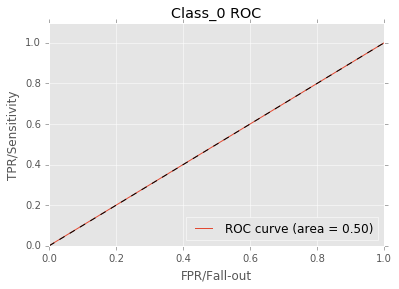

In [2705]:
y_true_Class_0 = y_class.Cancel_0
y_true_Class_1 = y_class.Cancel_1

y_hat_Class_0 = model_sk_Class_0.predict(X)
y_hat_Class_1 = model_sk_Class_1.predict(X)
fpr, tpr, thresholds = metrics.roc_curve(y_true_Class_1, y_hat_Class_1)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Class_0 ROC")
plt.legend(loc = 'lower right')
plt.show()

# Accuracy is poor on the entire Data set- Bringing back stratified sampling

6264
1.0    3132
0.0    3132
Name: Cancel_0, dtype: int64
1.0    3132
0.0    3132
Name: Cancel_1, dtype: int64
1.0    6264
dtype: int64
The values in Class 1 array([ 0.,  1.])--
The values in Class 0 array([ 1.,  0.])--
The score on Class_0 --0.71583652618135374
The score on Class_1 --0.28416347381864621
Output
0.0    3238
1.0    3026
dtype: int64
1.0    3238
0.0    3026
dtype: int64
1.0    6264
dtype: int64
 The AUC for Class_0


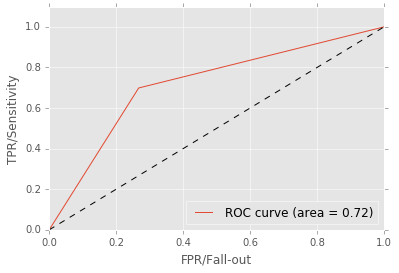

 The AUC for Class_1


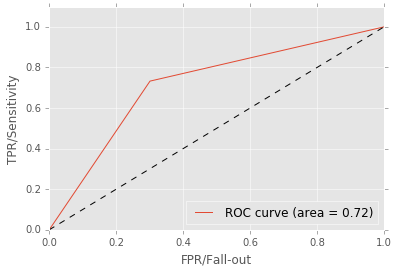

In [2706]:
#for i in range(10):
#print "Iteration %r--" %i
y_0 = df[df.Car_Cancellation == 0]
y_1 = df[df.Car_Cancellation == 1]
n = min([len(y_0), len(y_1)])
y_0 = y_0.sample(n = n, random_state = 0)
y_1 = y_1.sample(n = n, random_state = 0)
df_strat = pd.concat([y_0, y_1])
X_strat = df_strat[['online_booking','mobile_site_booking','vehicle_type','travel_type_id','frequent_user','Req_start_Month','Creation_Month','from_Outside_City','To_Outside_City','Popular_Pickup']]
y_strat = df_strat.Car_Cancellation
y_strat_class = pd.get_dummies(df_strat.Car_Cancellation,prefix = 'Cancel')
print len(y_strat_class)
sk_model(X_strat,y_strat_class)

# Decision Tree

In [2707]:
model_tree = tree.DecisionTreeRegressor()

model_tree.fit(X_strat, y_strat_class)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [2708]:
model_tree.score(X_strat, y_strat_class)

0.49750402380050363

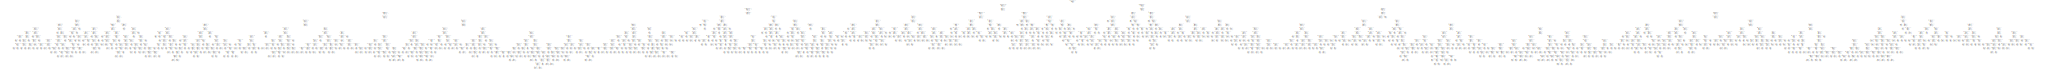

In [2709]:
  %reload_ext gvmagic


dot_data = externals.six.StringIO()
tree.export_graphviz(model_tree, out_file = dot_data, feature_names = X_strat.columns)
%dotstr dot_data.getvalue()

# Forest

In [2710]:
model_forest = ensemble.RandomForestClassifier( oob_score = True)
model_forest.fit(X_strat, y_strat_class)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [2711]:
model_forest.score(X_strat, y_strat_class)

0.80970625798212004

In [2712]:
sorted(zip(model_forest.feature_importances_, X_strat.columns.values), reverse = True)

[(0.21002761316674881, 'Creation_Month'),
 (0.18247071039724488, 'Req_start_Month'),
 (0.13469528801962588, 'online_booking'),
 (0.079487391106784475, 'travel_type_id'),
 (0.074919152875964956, 'frequent_user'),
 (0.074200890909666112, 'vehicle_type'),
 (0.070009612845930394, 'To_Outside_City'),
 (0.066994468030000337, 'from_Outside_City'),
 (0.056895057924972549, 'Popular_Pickup'),
 (0.050299814723061644, 'mobile_site_booking')]

In [2713]:

model_forest.oob_score_

0.73068326947637297